# **Transformers**
## **Video to Story System <br>**
## **Image Captioning Model:**

## Installs and Imports

In [1]:
!pip install "deeplake<4"
!pip install --upgrade transformers
!pip install nltk
!pip install torchvision
!pip install pycocoevalcap
!pip install tqdm
!pip install torch torchvision Pillow numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Created wheel for deeplake: filename=deeplake-3.9.33-py3-none-any.whl size=755193 sha256=b169277e6a5dbc771dc84ab102b50025cb3d2eaeb420e2a876a8accb17560fb9
  Stored in directory: /Users/joshdeleeuw/Library/Caches/pip/wheels/b4/9f/0e/abb0060f8490e3c88513188234db62ab7cc9bca5731963149f
Successfully built deeplake
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.0
    Uninstalling numpy-2.0.0:
      Successfully uninstalled numpy-2.0.0
  Attempting uninstall: deeplake
    Found existing installation: deeplake 4.0.3
    Uninstalling deeplake-4.0.3:
      Successfully uninstalled deeplake-4.0.3
ERROR: pip's depe

In [2]:
import torch
import torch.nn as nn

import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms
from transformers import BertTokenizer, BertModel
import nltk
import random

from torch.utils.data import Dataset
from PIL import Image

import unittest
from torch.utils.data import DataLoader
from torchvision import transforms
import collections

/Users/joshdeleeuw/opt/anaconda3/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.0) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/Users/joshdeleeuw/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing Data, Tokenizing

This was also part of our demo1 submission

In [3]:
ds = deeplake.load('hub://activeloop/flickr30k')

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



\

hub://activeloop/flickr30k loaded successfully.



In [4]:
images = ds.image
captions = ds.caption_0 ## NextSteps: currently only training on caption0, could include other set of captions

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
caption_max_length = 20
vocab_size = len(tokenizer)

In [9]:
def process_image(image):
  """
  Image transformation functions
  Resizes images to 224x224, converts to tensor, and normalizes
  The normalization parameters are mean, SD of of r, g, b pixel values
  """
  image_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = image.numpy()
  image = Image.fromarray(image)
  image = image_transform(image)
  return image


def process_caption(caption_text):
  """
  Tokenizes captions
  Returns tensor of tokenized captions, with a max length of 20,
  padding until this length, and truncating if the caption is longer
  The individual entries in the tensor are integers
  """

  tokenized = tokenizer(caption_text,
                        max_length=caption_max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']
  return input_ids

def untokenize(tokenized_text):
    """
    Untokenizes a tensor
    Takes a tensor of integers, and according to tokenizer, returns
    original words
    """
    return tokenizer.decode(tokenized_text, skip_special_tokens=True)


### Tests

Tokenizer Tests

In [10]:
strings = ["hello world", "my dog went to the store", "the earth revolves around the sun",
           "I travelled to new york city and ate mexican and japanese food"]

def test_tokenizer(strings):
    """
    Function to test tokenizer, by tokenizing and untokenizing a string
    """
    for string in strings:
        # print ("input string: " + string)
        check = untokenize(process_caption(string)[0])
        # print ("output string: " + check)
        assert check.lower() == string.lower()
    print("All tests passed!")
test_tokenizer(strings)

All tests passed!


In [11]:
tokenizer.tokenize("Hello I am Wendy")
tokenizer.encode("Hello I am Wendy", add_special_tokens = True)

[101, 7592, 1045, 2572, 12815, 102]

Data Processing Tests

In [12]:
def test_process_image():
  test_img = ds.image[0]
  transformed_img = process_image(test_img)
  assert transformed_img.size(1) == 224 and transformed_img.size(2) == 224, "Image resizing failed."
  assert transformed_img.size(0) == 3, "Image channel mismatch."
  print("All tests passed!")

test_process_image()


All tests passed!


In [13]:
def test_process_caption():
  caption = "A dog playing in the park."
  input_ids = process_caption(caption)
  assert input_ids.size(1) == 20, "Tokenized length incorrect."

  decoded_caption = untokenize(input_ids[0])
  assert decoded_caption.lower() == caption.lower(), "Caption untokenization incorrect."
  print("All tests passed!")
test_process_caption()

All tests passed!


## Dataset/Dataloader Creation

In [14]:
class Flickr30kDataset(Dataset):
    def __init__(self, images, captions, image_transform=None, caption_transform = None):
      """
      Initializes dataset
      """
      self.images = images
      self.captions = captions
      self.image_transform = image_transform
      self.caption_transform = caption_transform

    def __len__(self):
      """
      Returns length of the dataset
      """
      return len(self.captions)

    def __getitem__(self, idx):
      """
      Returns a single item (image, and caption processed according to
      caption_transform) from the dataset
      """
      image = self.images[idx]
      image = self.image_transform(image)

      caption = self.captions[idx].numpy()[0]
      caption_embedding = self.caption_transform(caption)
      return image, caption_embedding


In [15]:
from torch.utils.data import DataLoader, random_split

flickr_dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)

# 80% train, 10% val, 10% Test
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, eval_dataset, test_dataset = random_split(flickr_dataset, [train_size, val_size, test_size])

batch_size = 32 # TODO
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
## SMALLER DATASET FOR SAMPLE
from torch.utils.data import Subset
import random

train_n = 10 # (we set to 5000 to train our final model)
eval_n = 2
batch = 32

train_indices = random.sample(range(len(flickr_dataset)), train_n)
train_subset = Subset(flickr_dataset, train_indices)
mini_train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=False)

eval_indices = random.sample(range(len(flickr_dataset)), eval_n)
eval_subset = Subset(flickr_dataset, eval_indices)
mini_eval_dataloader = DataLoader(eval_subset, batch_size=batch, shuffle=False)

#### Tests

In [17]:
def test_flickr30k_dataset():
    dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)
    assert len(dataset) == len(captions), "Dataset length mismatch."

    image, caption_embedding = dataset[0]
    assert image.size(0) == 3 and image.size(1) == 224 and image.size(2) == 224, "Image shape incorrect."
    assert caption_embedding.size(1) == 20, "Caption max length incorrect."
    print("All tests passed!")

test_flickr30k_dataset()

All tests passed!


# Transformer-Based Image Captioning
Loosely based on : https://www.tensorflow.org/text/tutorials/image_captioning

Steps :  

1. Feature Extraction of Image (CNN)

2. Word Embedding : word + positional embedding

3. Decode Layer : Self attention, Cross Attention, Feed Forward Neural Network

4. Output : Post Processing of probability vector

## Feature Extraction

In [18]:
## Hyperparameter
embed_dim = 256

In [19]:
class CNN_feature_extraction(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN_feature_extraction, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1).to(device) # (224,224,64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1).to(device)# (224,224,128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1).to(device)# (224,224,256)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(256 * 28 * 28, 512).to(device)
    self.fc2 = nn.Linear(512, embed_dim).to(device)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d(2, 2).to(device)

    self.batchNorm1 = nn.BatchNorm2d(64).to(device)
    self.batchNorm2 = nn.BatchNorm2d(128).to(device)
    self.batchNorm3 = nn.BatchNorm2d(256).to(device)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    Note: Output is already flattened
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x)))) # batch_size, 64, 112, 112 (b, c , h, w )
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1)))) # batch_size, 128, 56, 56
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2)))) # batch_size, 256, 28, 28
    x1 = self.flatten(layer3)  # 1, 200704 = 256*28*28
    hidden = self.relu(self.fc(x1))
    x = self.fc2(hidden) # 1, 256
    return x

#### Tests for feature extractions

In [20]:
def test_feature_extraction():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0].to(device)
    label = labels[0].to(device)  # Corresponding label (if available)

    feature_extractor = CNN_feature_extraction()
    features = feature_extractor(image.unsqueeze(0))
    assert features.size(0) == 1, "CNN dimension batch size incorrect."
    assert features.size(1) == embed_dim, "CNN dimension incorrect."
    print("Test Passed!")

device = "cuda" if torch.cuda.is_available() else "cpu"
test_feature_extraction()

Test Passed!


## Embedding Layer
Embedding = Word + Positional Embedding.

In [23]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_length, dim):
        """
        Combines token and positional embeddings to produce sequence embeddings for Transformers.
        Input:
          vocab_size: size of vocab. Used for token embedding
          max_length: max length of caption. Used for positional embedding
          dim: Dimension of embedding vectors. Dimension of both token and positional Embedding
        """

        super().__init__()
        self.pos_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=embed_dim).to(device)
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0).to(device) # ie padding_idx that = 0 will not be trained

    def forward(self, caption):
        """
          Input: Caption (batch, max_length = 20)
          Output: Embedding (batch, max_length, dim)
        """
        _, max_length = caption.shape

        token_embed = self.token_embedding(caption)

        # Create a positional array with length = caption length (20)
        positional_indices = torch.arange(max_length, device=caption.device).unsqueeze(0).to(device) # 1, 20
        position_embed = self.pos_embedding(positional_indices)

        return token_embed + position_embed

#### Test for embedding layer

In [24]:
def test_embedding_layer():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0].to(device)
    label = labels[0].to(device)  # Corresponding label (if available)

    embedding = Embedding(vocab_size,caption_max_length,embed_dim)
    seq_embed = embedding(label)
    assert seq_embed.shape == (1,caption_max_length,embed_dim), "CNN dimension incorrect."
    print("Test Passed!")

device = "cuda" if torch.cuda.is_available() else "cpu"
test_embedding_layer()

Test Passed!


## Decoder
Contains self attention, cross attention, feed forward neural network

In [25]:
## Hyperparameters
num_heads = 1
dropout =  0.1

### Self Attention Layer

In [26]:
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism for token embeddings. Capture dependencies between words.

    Inputs:
        embed_dim: Embedding dimension = embed_dim
        num_heads: The number of attention heads. Each head learns different aspects of the relationships between tokens.
        dropout: Dropout rate used to prevent overfitting
    """
    def __init__(self,  num_heads = 1, embed_dim = embed_dim, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout).to(device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, x_token):
        """
        input shape : (batch, max_length, dim)
        output shape : (batch, max_length, dim)
        """
        attn_output, attn_output_weights = self.attention(query=x_token, key=x_token, value=x_token)
        x = x_token + attn_output  #Residual connection prevent vanishing grad
        return self.layernorm(x)

### Cross Attention Layer

In [27]:
class CrossAttention(nn.Module):
    """
    Cross Attention between caption and image.

    Input:
        Caption Embedding : (batch, seq_length, embed_dim)
        Image Feature Extraction : (batch, 256)
    """

    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout).to(device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, caption, image):
        batch_size_c, seq_length, embed_dim = caption.shape
        batch_size_i, image_embed = image.shape
        assert batch_size_c == batch_size_i, "Batch Dimension of image and caption does not match"
        # assert image_embed == 256, "Image Shape Incorrect"
        # assert image_embed == embed_dim , "Image dimension does not match Token dimension"

        # create the same image for seq_length
        image_broadcasted = image.unsqueeze(1).repeat(1, seq_length, 1) # batch, seq_length, image_dim
        attn_output, attention_scores = self.mha(query=caption, key=image_broadcasted, value=image_broadcasted)
        caption = caption + attn_output  # Residual connection
        # self.last_attention_scores = attention_scores
        return self.layernorm(caption)  #(batch, max_length, image_dim)

### Feed Forward Neural Network

In [28]:
class FeedForward(nn.Module):
    """
    Initializes feed forward layer, which passed data along to the
    next layer
    """
    def __init__(self, embed_dim, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(embed_dim, 2 * embed_dim).to(device),
            nn.ReLU(),
            nn.Linear(2 * embed_dim, embed_dim).to(device),
            nn.Dropout(dropout_rate)
        )
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, x):
        x = x + self.layer(x).to(device)
        return self.layernorm(x)


### Decoder Layer

In [29]:
class DecoderLayer(nn.Module):
    """
    Initializes full decoder layer, including self/cross attention layers
    and feed forward network
    """
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = SelfAttention(num_heads, embed_dim, dropout)
        self.cross_attention = CrossAttention(embed_dim, num_heads, dropout)
        self.ffnn = FeedForward(embed_dim, dropout)

    """
    Runs forward pass of the deocder layer
    """
    def forward(self, inputs):
        image, caption = inputs
        caption_1 = self.self_attention(caption)
        output_seq = caption_1
        # output_seq = self.cross_attention(caption_1, image)
        out_seq = self.ffnn(output_seq)

        # self.last_attention_scores = self.cross_attention.last_attention_scores

        return out_seq # batch, seq_length, embed_dim

## PostProcessing

1. Problem: Some tokens occur much more frequently than others in the dataset.
Without adjustment, the model may develop a bias toward predicting these frequent tokens, regardless of context.
Incorporate token frequency information in the logits using the bias term.
For instance, less frequent tokens are given a higher weight, encouraging the model to predict them when appropriate.

2. Problem: Some tokens, like [UNK] or [START], are placeholders or special tokens not intended for prediction.
Solution:
Add a large negative bias (-1e9) to these tokens' logits to make their probabilities effectively zero after softmax.
This guarantees they are not predicted during decoding.

In [30]:
import collections
from tqdm import tqdm

In [31]:
class PostProcessing(nn.Module):
    """
    Initializes post processing layer, which biases against some tokens
    and incorporates frequency information about the text
    """
    def __init__(self, embed_dim, tokenizer, banned_tokens=('[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in')):

        super(PostProcessing, self).__init__()
        self.vocab_size = tokenizer.vocab_size
        self.tokenizer = tokenizer
        self.fc = nn.Linear(embed_dim, out_features=tokenizer.vocab_size).to(device) ## Goal is to map to vocab size # batch, seq_length, vocab_size
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, dataset):
        """
            vocab_dict: a dictionary to map vocab word to assigned index (from 0 to vocab_size)
            counts : a dictionary holding frequency of each word(token), key: id value :freq
        """
        counts = collections.Counter()
        vocab_dict = {name: id for id, name in enumerate(self.tokenizer.vocab)} # map name to id


        for tokens in tqdm(dataset):
            counts.update(tokens.numpy().flatten())  # Update freq for token in the sentence

        # Turn Frequency into an array of all vocabulary
        # fill vocab array with freq
        # array indices = token_id
        counts_arr = np.zeros(shape=(self.vocab_size,))
        indices = np.array(list(counts.keys()), dtype=np.int32)
        counts_arr[indices] = list(counts.values())


        for token in self.banned_tokens:
            id = vocab_dict[token]
            counts_arr[id] = 0

        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0  # Prevent log(0)
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p * p).sum()

        self.bias = torch.tensor(log_p, dtype=torch.float32)
        self.bias[counts_arr == 0] = -1e9  # Set large negative values for banned tokens

    def forward(self, input):
        input = input.float()
        x = self.fc(input)
        # x = x + self.bias.to(x.device)  # Ensure bias is on the same device as the input
        return x

## Image Captioner : Put it all together

In [32]:
banned_tokens=('[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in')

class ImageCaption(nn.Module):
    """
    Combines all portions to initialize entire image captioner
    """
    def __init__(self, tokenizer, vocab_size, num_layers=1, embed_dim=256, max_length=20, num_heads=2, dropout=0.1):
        super(ImageCaption, self).__init__()

        self.feature_extractor_model = CNN_feature_extraction()
        self.embedding = Embedding(vocab_size , max_length, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim)
        self.post_processing_model = PostProcessing(embed_dim, tokenizer, banned_tokens = banned_tokens)

        self.tokenizer = tokenizer


    def forward(self, inputs):
        image, caption = inputs

        # Step 1: Extract Features
        extracted_image = self.feature_extractor_model(image)

        # Step 2: Embed the tokens
        tokens = self.embedding(caption)

        # Step 3: Decode
        token_output = self.decoder_layer((extracted_image, tokens))

        output = self.post_processing_model(token_output)

        return output

## Training/Predicting

This may be adapted and used for the final submission, but is not a core part of
our demo 2

In [33]:
import os

os.makedirs("./model_checkpoint_new", exist_ok=True)

def save_checkpoint(model, optimizer, epoch, path="model_checkpoint.pth"):
    """
    Saves model at particular iteration, to avoid repeated training
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1  # Save the next epoch to resume correctly
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

def train_model_one(model, dataloader, optimizer, criterion, epochs, tokenizer, device):
    """"
    Trains image captioning model on input data
    Parameters:
      model: image captioning model
      dataloader: object to load dataset
      optimizer: algorithm to update weights
      criterion: used for calculating loss function
      epochs: number of epochs to run
      tokenizer: tokenizer to use for model
      device: device model runs on (cuda or cpu)
    """
    print ("device is: " + str(device))
    model.train()
    count = 0
    for image, c in mini_train_dataloader:
      captions_list = c[0][0].tolist()  # Convert tensor to list
      # print (captions_list)
      decoded_captions = [tokenizer.decode(cap) for cap in captions_list]
      # print (decoded_captions)

      if count == 0:
        all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
      count += 1
      all_captions = torch.cat((all_captions, c.flatten()))

    model.post_processing_model.adapt(all_captions)

    for epoch in range(epochs):
        print("working on epoch ", epoch)
        total_loss = 0
        count = 0
        for images, captions in dataloader:
            count += 1

            #images = batch['images'].to(device)
            #captions = batch['captions'].to(device)


            images = images.to(device)
            captions = captions.to(device).long()

            decoder_input = captions.squeeze(1)[:, :-1]
            targets = captions.squeeze(1)[:, 1:]

            outputs = model((images, decoder_input))

            if count % 10 == 0:
              print (f"{count * 32/100}% done")

            loss = criterion(outputs.reshape(-1, tokenizer.vocab_size), targets.reshape(-1))
            # loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
        if epoch == 0:
            print (f"Total images is {count}")

        # Save checkpoint after every 10 epochs
        if (epoch + 1) % 5 == 0:
          save_checkpoint(model, optimizer, epoch, path=f"./model_checkpoint_new/checkpoint_epoch_{epoch+1}.pth")

In [34]:
# if only training on 10 images, should train very fast
image_caption_model = ImageCaption(tokenizer, vocab_size)
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 10  # (we set to 30 for training large model)
model = image_caption_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
train_model_one(model, mini_train_dataloader, optimizer, criterion, epochs, tokenizer, device)

device is: cpu


100%|██████████| 200/200 [00:00<00:00, 34890.02it/s]


working on epoch  0
Epoch [1/10], Loss: 10.4329
Total images is 1
working on epoch  1
Epoch [2/10], Loss: 9.7873
working on epoch  2
Epoch [3/10], Loss: 9.1786
working on epoch  3
Epoch [4/10], Loss: 8.5490
working on epoch  4
Epoch [5/10], Loss: 7.9734
Checkpoint saved at ./model_checkpoint_new/checkpoint_epoch_5.pth
working on epoch  5
Epoch [6/10], Loss: 7.4291
working on epoch  6
Epoch [7/10], Loss: 6.9140
working on epoch  7
Epoch [8/10], Loss: 6.4702
working on epoch  8
Epoch [9/10], Loss: 5.9992
working on epoch  9
Epoch [10/10], Loss: 5.5743
Checkpoint saved at ./model_checkpoint_new/checkpoint_epoch_10.pth


In [35]:
def evaluate_model(model, dataloader, tokenizer, device, criterion, max_length=20):
    """
    Evaluate the model on the validation dataset.
    Args:
        model: Trained model.
        dataloader: Validation dataloader.
        tokenizer: Tokenizer used for captions.
        device: Device to run evaluation on (CPU or GPU).
        criterion: Loss function to calculate evaluation loss.
        max_length: Maximum length for caption generation.
    Returns:
        Average evaluation loss and generated captions.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    generated_captions = []

    with torch.no_grad():
        for images, captions in dataloader:
            # compute loss for every image
            images = images.to(device)
            captions = captions.to(device).long()

            decoder_input = captions.squeeze(1)[:, :-1]
            targets = captions.squeeze(1)[:, 1:]

            outputs = model((images, decoder_input))
            loss = criterion(outputs.reshape(-1, tokenizer.vocab_size), targets.reshape(-1))

            total_loss += loss.item()

    print (len(dataloader))
    avg_loss = total_loss / len(dataloader)
    print(f"Evaluation Loss: {avg_loss:.4f}")
    return avg_loss, generated_captions


In [37]:
use_pretrained_model = True
checkpoint_path = "checkpoint_final.pth"
if use_pretrained_model:
  model = ImageCaption(tokenizer, vocab_size)
  if torch.cuda.is_available():
    model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
  else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['model_state_dict'])
evaluate_model(model, mini_eval_dataloader, tokenizer, device, criterion)

1
Evaluation Loss: 5.4624


(5.462360858917236, [])

In [38]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def predict_one(model, dataset, image, idx, device, max_length=20):
    """
    Predict the caption for an image from the dataset at a given index.
    Args:
        model: The trained ImageCaption model.
        dataset: The deeplake dataset containing images.
        idx: The index of the image in the dataset.
        device: The device (CPU or GPU) to run the model on.
        max_length: Maximum length of the generated caption.
    Returns:
        The predicted caption as a string.
    """
    # Load and preprocess the image
    # image = dataset.image[idx].numpy()
    # processed_image = process_image(image).unsqueeze(0).to(device)
    image = image.to(device)

    # Start the generation process
    with torch.no_grad():
        # Step 1: Extract image features

        extracted_image = model.feature_extractor_model(image)

        # Step 2: Start with the <START> token
        captions = torch.full(
            (1, 1), tokenizer.convert_tokens_to_ids("<START>"),
            dtype=torch.long, device=device
        )

        # Step 3: Autoregressively generate caption
        for _ in range(max_length):
            # Embed tokens
            token_embeddings = model.embedding(captions)

            # Decode with cross-attention
            token_output = model.decoder_layer((extracted_image, token_embeddings))

            # Post-process to predict the next token
            logits = model.post_processing_model(token_output[:, -1, :])  # Use the last token's output
            next_token = logits.argmax(dim=-1).unsqueeze(1)  # Select the most probable token

            # Append the next token to the captions
            captions = torch.cat([captions, next_token], dim=1)

            # Stop if the <END> token is generated
            if next_token.item() == tokenizer.convert_tokens_to_ids("<END>"):
                break

    # Untokenize the generated tokens
    return untokenize(captions.squeeze(0).tolist())

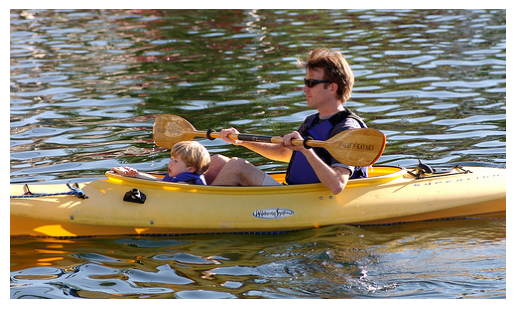

Predicted Caption: a man in a green day while standing in the water, one man with a forest nearby


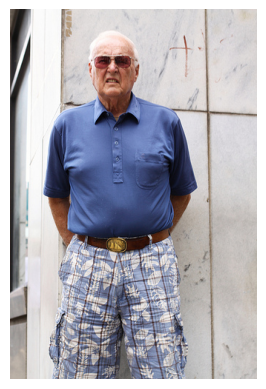

Predicted Caption: a man in a blue shirt and a red shirt, one in a bike.


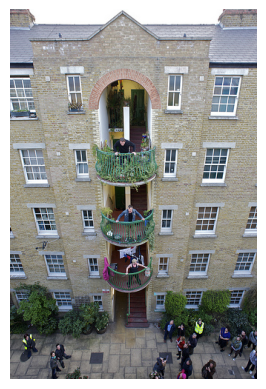

Predicted Caption: a man in a green day so he is looking at the sun, while a white shirt


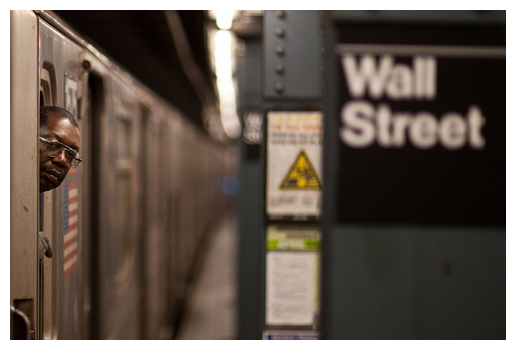

Predicted Caption: a man in a red shirt and a white boat with a blue water.


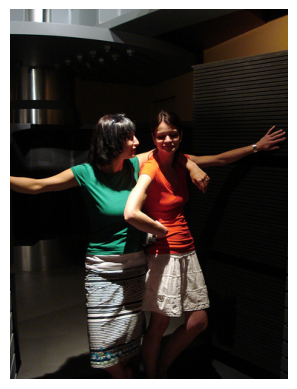

Predicted Caption: a man in a red shirt is cooking with a wooden floored apartment building.


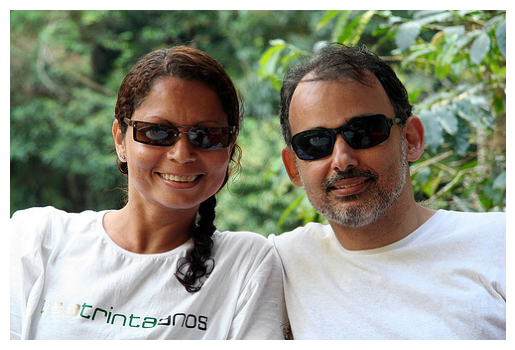

Predicted Caption: a man in a blue shirt is cooking with a red shirt, while a white and pointing


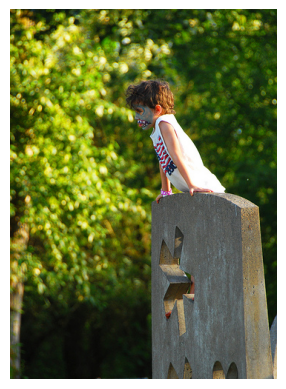

Predicted Caption: a man in a red shirt is cooking a seat for the sun, one in a red


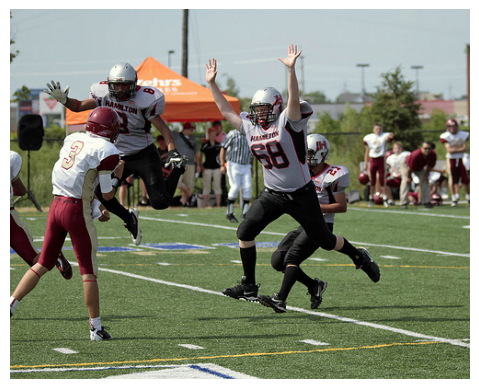

Predicted Caption: a man in a green day so he can cross a few of a wooden fence.


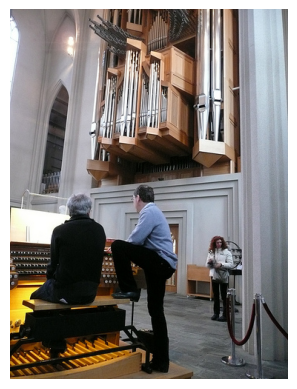

Predicted Caption: a man in a red shirt is cooking with a blue van and a white shirt are standing


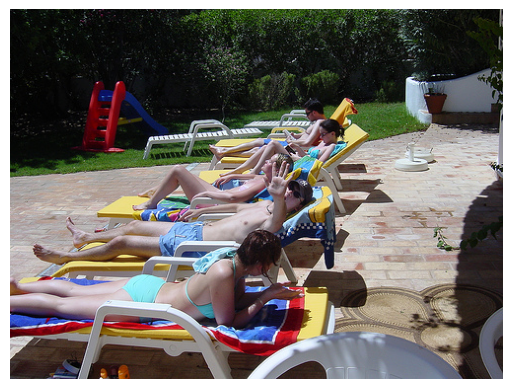

Predicted Caption: a man in a green day so he is looking into a blue car that says " p


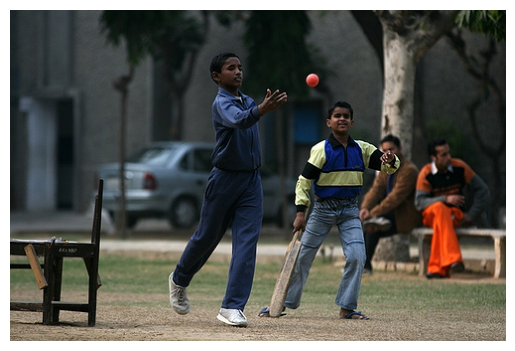

Predicted Caption: a man in a green shirt and a red shirt, one of incredible trick in a cloth


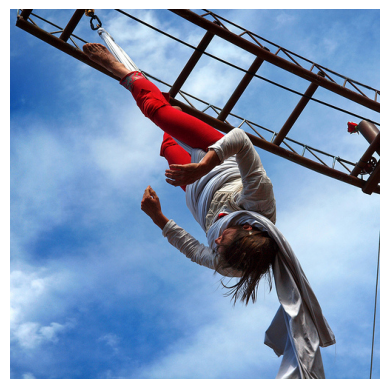

Predicted Caption: a man in a blue shirt and a red shirt, one in the water.


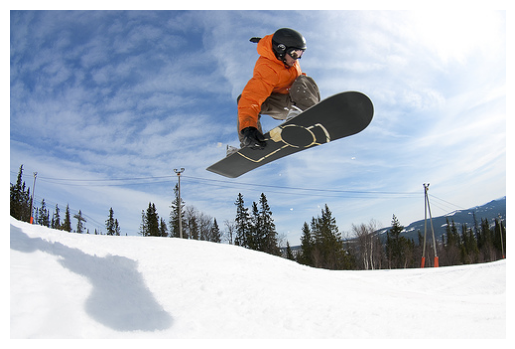

Predicted Caption: a man in a red shirt is cooking with a green shirt, while a white and pointing


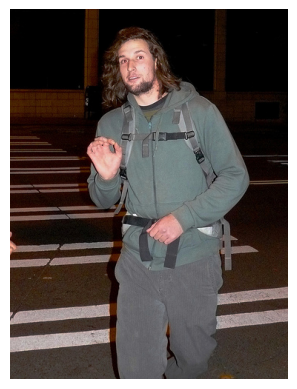

Predicted Caption: a man in a red shirt is cooking with a wooden floored apartment building.


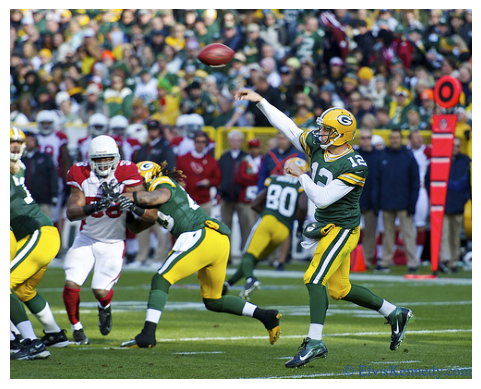

Predicted Caption: a man in a blue shirt and a white shirt, one of a red curb at the


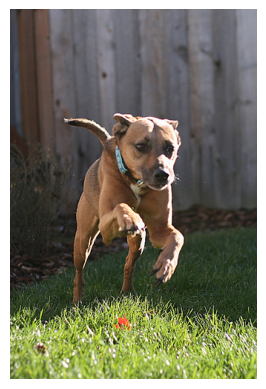

Predicted Caption: a man in a red shirt is cooking a woman, one in a wooden fence.


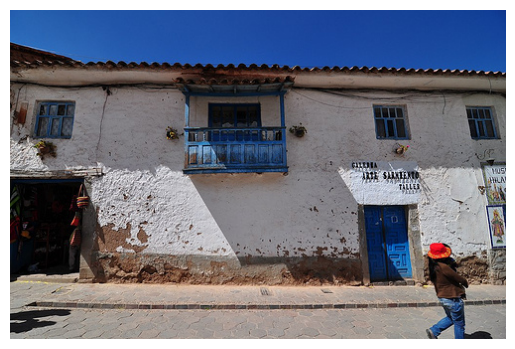

Predicted Caption: a man in a red shirt is standing in the ocean whilst taking a white shirtless,


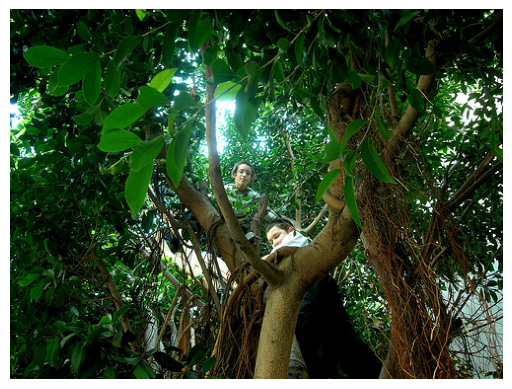

Predicted Caption: a man in a red shirt is standing in the snowball guns.


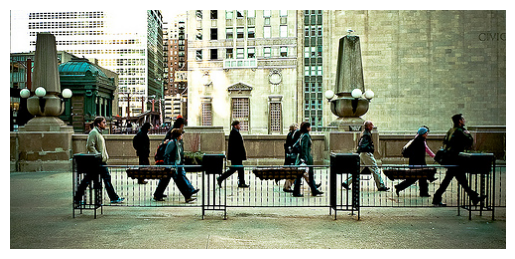

Predicted Caption: a man in a green shirt is cooking with a blue van and taking a wooden clear glass


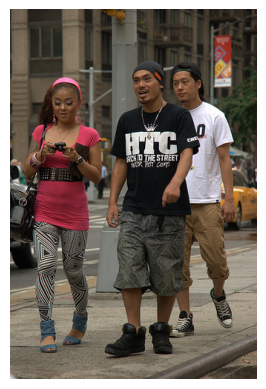

Predicted Caption: a man in a green day so he is looking into the sun, while a camera.


In [40]:
use_pretrained_model = True
checkpoint_path = "checkpoint_final.pth"
if use_pretrained_model:
  model = ImageCaption(tokenizer, vocab_size)
  if torch.cuda.is_available():
    model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
  else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['model_state_dict'])
# Predict for a specific image
for index in range(10, 30):
  if index not in train_indices:
    plt.imshow(ds.image[index].numpy())
    plt.axis('off')
    plt.show()

    test_image = ds.image[index]
    processed_test_image = process_image(test_image).unsqueeze(0)
    predicted_caption = predict_one(model, ds, processed_test_image, index, device)
    print(f"Predicted Caption: {predicted_caption}")

In [41]:
from torch.nn.functional import cosine_similarity

# cosine similarity under feature extraction for pairs of sample images
for i in range(10, 20):
  for j in range (i+1, 20):
    processed_test_image_1 = process_image(ds.image[i]).unsqueeze(0).to(device)
    processed_test_image_2 = process_image(ds.image[j]).unsqueeze(0).to(device)
    extracted_1 = model.feature_extractor_model(processed_test_image_1)
    extracted_2 = model.feature_extractor_model(processed_test_image_2)
    similarity = cosine_similarity(extracted_1, extracted_2).item()
    print(f"Cosine Similarity: {similarity}")

Cosine Similarity: 0.6348442435264587
Cosine Similarity: 0.6715478897094727
Cosine Similarity: 0.5409598350524902
Cosine Similarity: 0.580176830291748
Cosine Similarity: 0.6361185908317566
Cosine Similarity: 0.5757408738136292
Cosine Similarity: 0.5770832300186157
Cosine Similarity: 0.6622847318649292
Cosine Similarity: 0.6321839690208435
Cosine Similarity: 0.5900264978408813
Cosine Similarity: 0.46739262342453003
Cosine Similarity: 0.5363587737083435
Cosine Similarity: 0.5440443158149719
Cosine Similarity: 0.5175343751907349
Cosine Similarity: 0.5924714803695679
Cosine Similarity: 0.6131099462509155
Cosine Similarity: 0.595062792301178
Cosine Similarity: 0.46789833903312683
Cosine Similarity: 0.521299421787262
Cosine Similarity: 0.5671333074569702
Cosine Similarity: 0.5292810797691345
Cosine Similarity: 0.6571967601776123
Cosine Similarity: 0.6146131157875061
Cosine Similarity: 0.4963788390159607
Cosine Similarity: 0.5076403021812439
Cosine Similarity: 0.41034579277038574
Cosine Simil

# **Testing**

In [42]:
class TestImageCaptioningComponents(unittest.TestCase):
    """
    Sets up and runs image captioning tests
    """
    def setUp(self):
        self.vocab_size = 1000
        self.max_length = 20
        self.embed_dim = 256
        self.num_heads = 1
        self.dropout = 0.1
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # initialize using our classes
        self.embedding = Embedding(self.vocab_size, self.max_length, self.embed_dim).to(self.device)
        self.self_attention = SelfAttention(self.num_heads, self.embed_dim, self.dropout).to(self.device)
        self.cross_attention = CrossAttention(self.embed_dim, self.num_heads, self.dropout).to(self.device)
        self.feed_forward = FeedForward(self.embed_dim, self.dropout).to(self.device)

    # test for Embedding()
    def test_embedding_output_dim(self):
        caption = torch.randint(0, self.vocab_size, (1, self.max_length)).to(self.device)
        output = self.embedding(caption)
        self.assertEqual(output.shape, (1, self.max_length, self.embed_dim), "Embedding output dimensions are incorrect")

    # test for SelfAttention()
    def test_selfattention_output_dim(self):
        input_tensor = torch.rand(1, self.max_length, self.embed_dim).to(self.device)
        output = self.self_attention(input_tensor)
        self.assertEqual(output.shape, input_tensor.shape, "Self Attention output dimensions are incorrect")

    # test for CrossAttention()
    def test_crossattention_output_dim(self):
        caption_embedding = torch.rand(1, self.max_length, self.embed_dim).to(self.device)
        image_features = torch.rand(1, self.embed_dim).to(self.device)
        output=self.cross_attention(caption_embedding, image_features)
        self.assertEqual(output.shape, caption_embedding.shape, "Cross Attention output dimensions are incorrect")

    # test FeedForward()
    def test_feedforward_output_dim(self):
        input_tensor = torch.rand(1, self.max_length, self.embed_dim).to(self.device)
        output = self.feed_forward(input_tensor)
        self.assertEqual(output.shape, input_tensor.shape, "Feed Forward output dimensions are incorrect")

# Running the tests in the notebook
def run_tests():
    test_loader = unittest.TestLoader()
    test_suite = test_loader.loadTestsFromTestCase(TestImageCaptioningComponents)
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_results = test_runner.run(test_suite)
    print(test_results)

In [43]:
run_tests()

test_crossattention_output_dim (__main__.TestImageCaptioningComponents) ... ok
test_embedding_output_dim (__main__.TestImageCaptioningComponents) ... ok
test_feedforward_output_dim (__main__.TestImageCaptioningComponents) ... ok
test_selfattention_output_dim (__main__.TestImageCaptioningComponents) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.084s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>


Test PostProcessing

In [44]:
class MockTokenizer:
    def __init__(self, base_vocab_size):
        self.base_vocab_size = base_vocab_size
        self.banned_tokens = ['[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in']
        self.vocab = {str(i): i for i in range(base_vocab_size)}
        self.vocab.update({token: base_vocab_size + i for i, token in enumerate(self.banned_tokens)})

    @property
    def vocab_size(self):
        # This should return the total size including the banned tokens
        return self.base_vocab_size + len(self.banned_tokens)

    def banned_tokens_ids(self):
        return [self.vocab[token] for token in self.banned_tokens]

In [45]:
class TestPostProcessing(unittest.TestCase):
    def setUp(self):
        self.embed_dim = 256
        self.base_vocab_size = 1000  # Base vocabulary size excluding banned tokens
        self.tokenizer = MockTokenizer(self.base_vocab_size)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.banned_tokens = self.tokenizer.banned_tokens
        self.post_processing = PostProcessing(self.embed_dim, self.tokenizer, self.banned_tokens).to(self.device)

    def test_initial_bias(self):
        """Test that initial bias is None."""
        self.assertIsNone(self.post_processing.bias, "Initial bias should be None.")

    def test_adapt_bias_modification(self):
        """ Test the bias computation and adaptation """
        dataset = [torch.tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0]) for _ in range(10)]
        self.post_processing.adapt(dataset)

        banned_indices = [self.tokenizer.vocab.get(token, -1) for token in self.banned_tokens]
        banned_biases = {token: self.post_processing.bias[idx].item() for token, idx in zip(self.banned_tokens, banned_indices)}
        print("Banned biases:", banned_biases)

        self.assertTrue(all(self.post_processing.bias[1:5] < 0), "Regular token biases should be calculated and less negative.")

        for idx in banned_indices:
            self.assertTrue(self.post_processing.bias[idx] <= -1e6, f"Bias for banned token should be extremely negative.")

    def test_forward_output(self):
        """Test the forward pass output dimensions and values after bias has been set."""
        if self.post_processing.bias is None:
            dataset = [torch.tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0]) for _ in range(10)]
            self.post_processing.adapt(dataset)

        input_tensor = torch.randn(1, 20, self.embed_dim).to(self.device)
        self.post_processing.bias = self.post_processing.bias.to(input_tensor.device)

        output = self.post_processing(input_tensor)
        self.assertEqual(output.shape, (1, 20, self.base_vocab_size + len(self.banned_tokens)), "Output dimensions should match (batch, sequence length, vocab size).")

In [46]:
def run_tests_postprocessing():
    test_loader = unittest.TestLoader()
    test_suite = test_loader.loadTestsFromTestCase(TestPostProcessing)
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_results = test_runner.run(test_suite)
    print(test_results)

run_tests_postprocessing()

test_adapt_bias_modification (__main__.TestPostProcessing)
100%|██████████| 10/10 [00:00<00:00, 34521.02it/s]
ok
test_forward_output (__main__.TestPostProcessing)
Test the forward pass output dimensions and values after bias has been set. ... 

Banned biases: {'[UNK]': -1000000000.0, '[PAD]': -1000000000.0, '[SEP]': -1000000000.0, '[CLS]': -1000000000.0, '[MASK]': -1000000000.0, 'the': -1000000000.0, 'a': -1000000000.0, 'in': -1000000000.0}


100%|██████████| 10/10 [00:00<00:00, 36503.95it/s]
ok
test_initial_bias (__main__.TestPostProcessing)
Test that initial bias is None. ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.033s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>


In [47]:
class MockTokenizer_cap:
    def __init__(self):
        # Create a vocabulary that the PostProcessing class can use to map names to IDs
        self.vocab = {str(i): i for i in range(100)}  # Example vocabulary with 100 tokens
        self.banned_tokens = ['[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in']
        self.vocab = {**self.vocab, **{token: 100 + i for i, token in enumerate(self.banned_tokens)}}


    def encode(self, text):
        # Simulate encoding text into a sequence of token IDs
        return [self.vocab[str(i)] for i in range(len(text.split()))]

    def decode(self, tokens):
        # Simulate decoding a sequence of token IDs back into text
        return ' '.join(str(token) for token in tokens)

    @property
    def vocab_size(self):
        return len(self.vocab)


In [48]:
class TestImageCaption(unittest.TestCase):
    def setUp(self):
        self.tokenizer = MockTokenizer_cap()
        self.model = ImageCaption(
            self.tokenizer, vocab_size=100, num_layers=1, embed_dim=256, max_length=20, num_heads=2, dropout=0.1
        )
        self.model.eval()
        mock_captions = torch.randint(0, 100, (100, 20))
        self.model.post_processing_model.adapt(mock_captions)


    def test_initialization(self):
        """ Test if the model initializes without errors """
        self.assertIsInstance(self.model, ImageCaption)



    def test_component_interaction(self):
        """ Test interactions between components within the model """
        dummy_image = torch.rand(1, 3, 224, 224).to(device)
        dummy_caption = "another test caption"
        tokens = torch.tensor([self.tokenizer.encode(dummy_caption)]).to(device)

        # Forward pass
        image_features = self.model.feature_extractor_model(dummy_image)
        token_embeddings = self.model.embedding(tokens)
        decoded_output = self.model.decoder_layer((image_features, token_embeddings))
        final_output = self.model.post_processing_model(decoded_output)

        self.assertTrue(torch.is_tensor(image_features))
        self.assertTrue(torch.is_tensor(token_embeddings))
        self.assertTrue(torch.is_tensor(decoded_output))
        self.assertTrue(torch.is_tensor(final_output))

    def test_error_handling(self):
        """ Test the model's error handling for incorrect inputs """
        with self.assertRaises(Exception):
            self.model((torch.rand(5, 5), "wrong input type for caption"))

In [49]:
def run_tests_caption():
    test_loader = unittest.TestLoader()
    test_suite = test_loader.loadTestsFromTestCase(TestImageCaption)
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_results = test_runner.run(test_suite)
    print(test_results)

run_tests_caption()

test_component_interaction (__main__.TestImageCaption)
100%|██████████| 100/100 [00:00<00:00, 48517.11it/s]l ... 
ok
test_error_handling (__main__.TestImageCaption)
100%|██████████| 100/100 [00:00<00:00, 54203.98it/s] ... 
ok
test_initialization (__main__.TestImageCaption)
100%|██████████| 100/100 [00:00<00:00, 69488.14it/s]
ok

----------------------------------------------------------------------
Ran 3 tests in 1.499s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>


## Random Guessing Model (Post Demo 2)

In [50]:
def random_predict(data_loader, device='cpu'):
  """
  Selects random caption from the training set. Used as a benchmark for our model

  Parameters
  data_loader: where to load training images/captions from
  device: device to run on
  """
  caption_list = []
  for _, captions in data_loader:
    captions_list = captions[0][0].tolist()  # Convert tensor to list
    decoded_captions = [tokenizer.decode(cap) for cap in captions_list]
    caption_list.append(decoded_captions)
  selected = random.choice(caption_list)
  ending = selected.index('[SEP]')
  return ' '.join(selected[1:ending])

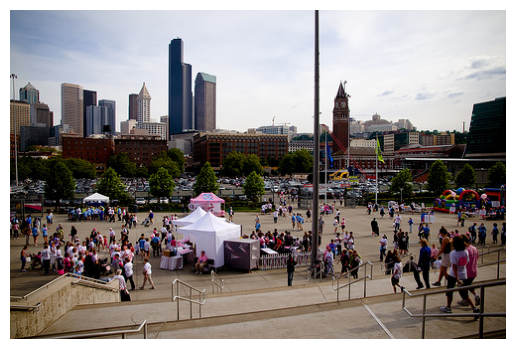

Actual Caption: Crowds of people are walking are multicolored tents and flags that are put up outside in a cement lot as a big city looms in the distance .
Predicted Caption: a photographer takes pictures of a family that includes four children and two parents


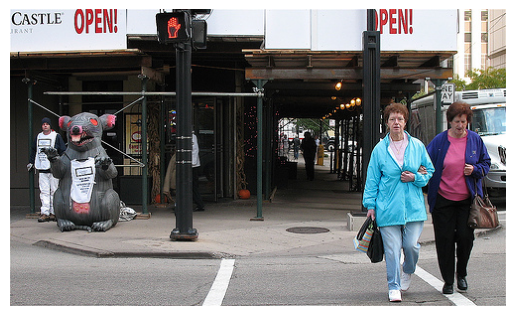

Actual Caption: Two women in a light blue and a dark blue jacket walking in a crosswalk and a fake giant rat is on the sidewalk behind them .
Predicted Caption: a photographer takes pictures of a family that includes four children and two parents


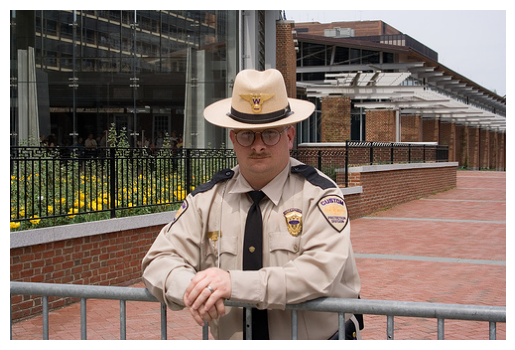

Actual Caption: A security officer with a tiny face and big glasses leans on a metal gate looking into the camera .
Predicted Caption: a photographer takes pictures of a family that includes four children and two parents


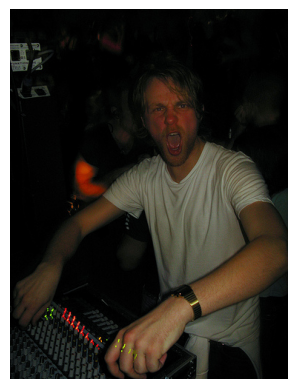

Actual Caption: A man with a white shirt with his mouth open wide and turning buttons .
Predicted Caption: a photographer takes pictures of a family that includes four children and two parents


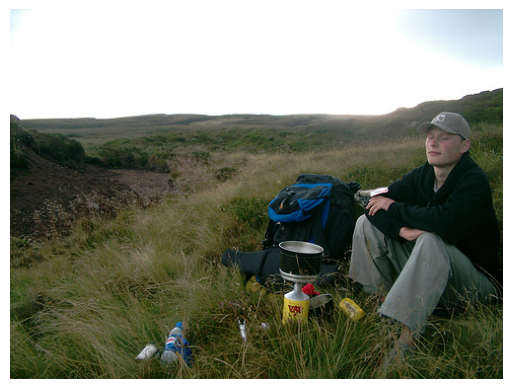

Actual Caption: A man enjoys a peaceful solitary moment while camping .
Predicted Caption: a photographer takes pictures of a family that includes four children and two parents


In [51]:
# Testing random captioning on sone indices
for index in range(0, 5):
  plt.imshow(ds.image[index].numpy())
  plt.axis('off')
  plt.show()

  test_image = ds.image[index]
  actual_caption = ds.caption_0[index].numpy()[0]
  print(f"Actual Caption: {actual_caption}")
  processed_test_image = process_image(test_image).unsqueeze(0)
  predicted_caption = random_predict(mini_train_dataloader)
  print(f"Predicted Caption: {predicted_caption}")

# Evaluation (Post Demo 2)

Bleu Score

In [55]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(index, caption):
  """
  Computes bleu evaluation score for an image caption at a given index,
  where 0 is worst and 1 is best

  Parameters:
  index - index of flickr dataset to evaluate (where to find image, true captions)
  caption - caption to evaluate, either from our model or random guessing model

  Returns:
  score - bleu score, float
  """

  # gets image, captions
  test_image = ds.image[index]
  caption_0 = ds.caption_0[index].numpy()[0].split()
  caption_1 = ds.caption_1[index].numpy()[0].split()
  caption_2 = ds.caption_2[index].numpy()[0].split()
  caption_3 = ds.caption_3[index].numpy()[0].split()
  caption_4 = ds.caption_4[index].numpy()[0].split()

  predicted_caption = caption.split()

  # computes bleu score
  smoothie = SmoothingFunction().method4
  score = sentence_bleu([caption_0, caption_1, caption_2, caption_3, caption_4],
                        predicted_caption, smoothing_function = smoothie)
  return score

CIDEr Score

In [56]:
from pycocoevalcap.cider.cider import Cider

def compute_cider(start_index, end_index, caption):
  """
  Computes average cider evaluation score for multiple image captions in range
  [start_index, end_index), returns average

  Parameters:
  start_index - starting index of flickr dataset to evaluate (where to find image, true captions)
  end_index - ending index of flickr dataset to evaluate (not inclusive)
  caption - the list of captions to evaluate, either from our model or random guessing model

  Returns:
  score - cider score, float
  """
  # gets image, captions for all indices in range
  refs = {}
  hyps = {}
  count = 0
  for index in range(start_index, end_index+1):
    refs[index] = [ds.caption_0[index].numpy()[0], ds.caption_1[index].numpy()[0], ds.caption_2[index].numpy()[0],
             ds.caption_3[index].numpy()[0], ds.caption_4[index].numpy()[0]]
    hyps[index] = [caption[count]]
    count += 1

  # computes cider score
  cider_scorer = Cider()
  score = cider_scorer.compute_score(refs, hyps)
  return score[0]

## Benchmarking with Bleu/Cider Scores (Post Demo 2)

In [63]:
def benchmark_bleu(start, end, data_loader, checkpoint_path, USE_RANDOM):
  """
  Benchmarks bleu score for our image captioning model. Using either random captions
  or generates from our model, then computes bleu scores from indices start...end.
  Returns the average of these scores.

  Parameters:
  start - starting index of flickr dataset to evaluate (where to find image, true captions)
  end - ending index of flickr dataset to evaluate (not inclusive)
  data_loader - where to load training images/captions from
  checkpoint_path - path to checkpoint to load model from
  USE_RANDOM - if True, use random captions. If False, use our model
  """
  scores = []
  for i in range(start, end+1):
    if USE_RANDOM:
      caption = random_predict(data_loader)
    else:
      test_image = ds.image[index]
      processed_test_image = process_image(test_image).unsqueeze(0)
      model = ImageCaption(tokenizer, vocab_size)
      if torch.cuda.is_available():
        model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
      else:
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['model_state_dict'])
      caption = predict_one(model, ds, processed_test_image, index, device)
    scores.append(compute_bleu(index, caption))
  return np.mean(scores)

In [64]:
def benchmark_cider(start, end, data_loader, checkpoint_path, USE_RANDOM):
  """
  Benchmarks cider score for our image captioning model. Using either random captions
  or generates from our model, then computes cider scores from indices start...end.
  Returns the average of these scores.

  Parameters:
  start - starting index of flickr dataset to evaluate (where to find image, true captions)
  end - ending index of flickr dataset to evaluate (not inclusive)
  data_loader - where to load training images/captions from
  checkpoint_path - path to checkpoint to load model from
  USE_RANDOM - if True, use random captions. If False, use our model
  """
  all_captions = []
  for i in range(start, end+1):
    if USE_RANDOM:
      caption = random_predict(data_loader)
    else:
      test_image = ds.image[index]
      processed_test_image = process_image(test_image).unsqueeze(0)
      model = ImageCaption(tokenizer, vocab_size)
      if torch.cuda.is_available():
        model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
      else:
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['model_state_dict'])
      caption = predict_one(model, ds, processed_test_image, index, device)
    all_captions.append(caption)
  return compute_cider(start, end,all_captions)

In [65]:
checkpoint_path = 'checkpoint_final.pth'

In [60]:
start = 80
end = 100
bleu_score_random = benchmark_bleu(start, end, mini_train_dataloader, checkpoint_path, True)
print (f"On {end - start} Images, Avergae BLEU Score of Random Guessing Model: {bleu_score_random}")

/Users/joshdeleeuw/opt/anaconda3/lib/python3.9/site-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


On 20 Images, Avergae BLEU Score of Random Guessing Model: 0.023143716762037452


In [66]:
start = 80
end = 100
bleu_score_model = benchmark_bleu(start, end, mini_train_dataloader, checkpoint_path, False)
print (f"On {end - start} Images, Avergae BLEU Score of Our Model: {bleu_score_model}")

On 20 Images, Avergae BLEU Score of Our Model: 0.05851762493853337


In [67]:
start = 80
end = 100
cider_score_random = benchmark_cider(start, end, mini_train_dataloader, checkpoint_path, True)
print (f"On {end - start} Images, Avergae CIDEr Score of Random Guessing Model: {cider_score_random}")

On 20 Images, Avergae CIDEr Score of Random Guessing Model: 0.014655566297740674


In [68]:
start = 80
end = 100
cider_score_model = benchmark_cider(start, end, mini_train_dataloader, checkpoint_path, False)
print (f"On {end - start} Images, Avergae CIDEr Score of Our Model: {cider_score_model}")

On 20 Images, Avergae CIDEr Score of Our Model: 0.05666985933418084
